## <font color='#90c149'>Imports</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Native imports
import os

In [3]:
#Library imports
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

## <font color='#90c149'>Setup</font>
We use images from the flair dataset. They are in TIF format and are composed of 5 channels.
- R
- G
- B
- NIR
- Elevation

In [4]:
# The relative path of the image being treated
tif_path = "./flair/dataflair/flair_1_toy_aerial_train/D031_2019/Z8_UU/img/IMG_020484.tif"
#tif_path ="../flair/dataflair/flair_1_toy_aerial_train/D032_2019/Z3_AA/img/IMG_022673.tif"


# <font color='#90c149'>Processing</font>

## <font color='#90c149'>Image Display</font>
First, we display the five channels of the image

In [5]:
from count.data import read_tif_image
from count.display import display_5channel_image

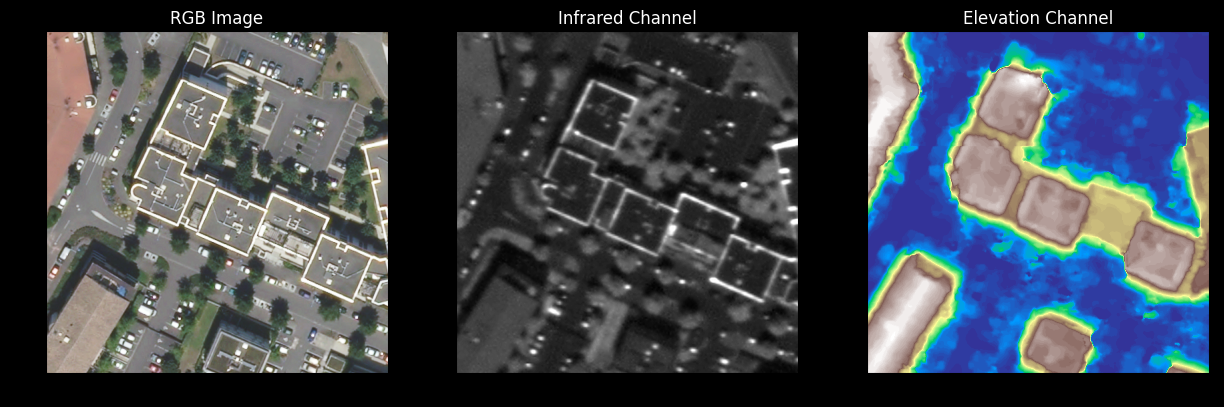

In [6]:
image=read_tif_image(tif_path)
display_5channel_image(image)

## <font color='#90c149'>NDVI Calculation and Display</font>
Then, we calculate the NDVI indice which reflects how likely a pixel is to represent vegetation in a picture. It is calculated like so :
$$NDVI = \frac{NIR - Red}{NIR + Red}$$

In [7]:
from count.display import display_NDVI_RGB

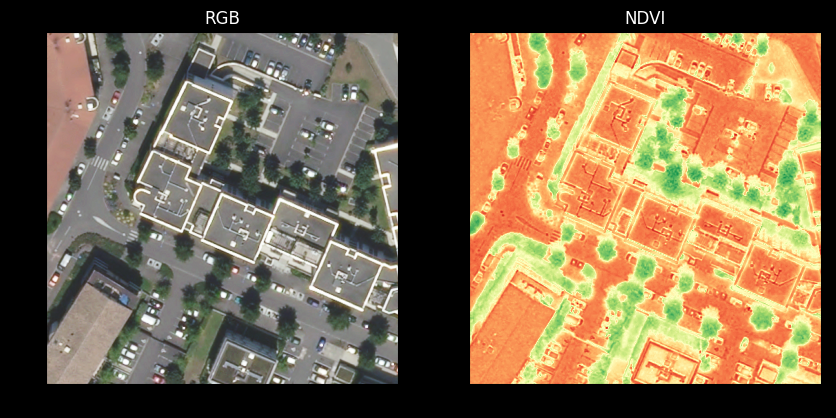

In [8]:
display_NDVI_RGB(image)

## <font color='#90c149'>Thresholds adjustement</font>
We want to remove the non-tree data of the image. In order to do so, we create a binary map from a threshold applied to the ndvi image.
$$binary(ndvi) = \begin{cases}
    1 & \text{if } ndvi>threshold \\
    0 & \text{otherwise}  \\
\end{cases}$$
We aim to set the threshold in order to see only the trees so that every tree is in a different related component in the image.

In [9]:
from count.processing import binary_threshold, NDVI 
from count.display import imshow
from ipywidgets import interact

In [10]:
image = read_tif_image(tif_path)
ndvi = NDVI(image)
@interact(minN=(-1, 1, 0.01), minE=(-1, 74, 1), maxE=(-1, 74, 1))
def threshold_and_blur(minN, minE, maxE):
    ndvi_thresholded = binary_threshold(ndvi, threshold_min=minN)
    elevation_thresholded = binary_threshold(image[:,:,4], threshold_min=minE, threshold_max=maxE)
    imshow(ndvi_thresholded, title="Only NDVI threshold")
    imshow(elevation_thresholded, title="Only elevation threshold")
    imshow(ndvi_thresholded*elevation_thresholded, title="Both thresholds")

interactive(children=(FloatSlider(value=0.0, description='minN', max=1.0, min=-1.0, step=0.01), IntSlider(valu…

We chose **minN = 0.2**, **minE = -1** and **maxE = 20** and define the fonction **binary_map(image)** accordingly.

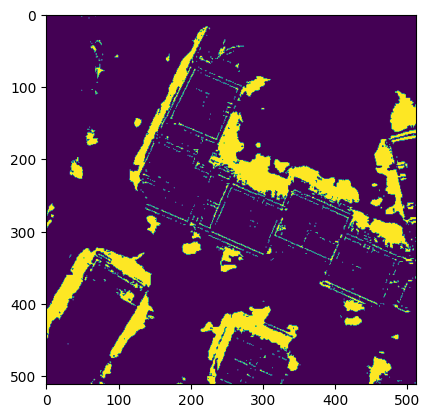

In [11]:
from count.processing import binary_map
imshow(binary_map(image))

We decide to keep a threshold of **0.22**

## <font color='#90c149'>Related components separation</font>
The aim is now to extract the related components of the image as they are likely to represent different groups of trees. In order to do so, we use the openCV library.

In [12]:
from count.processing import extract_connected_components, indice
from count.display import display_colorized_connected_components, display_colorized_connected_components_with_size_filtering

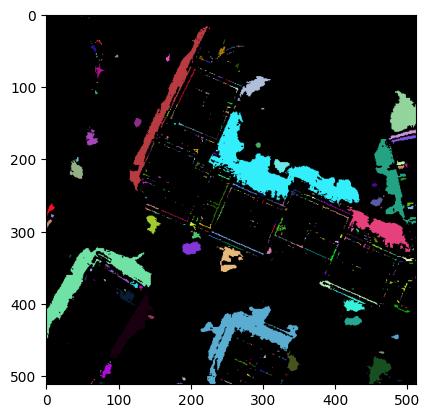

Number of connected components: 602


In [13]:
binary_image = binary_map(image)
display_colorized_connected_components(binary_image)

In [14]:
min_size = 25

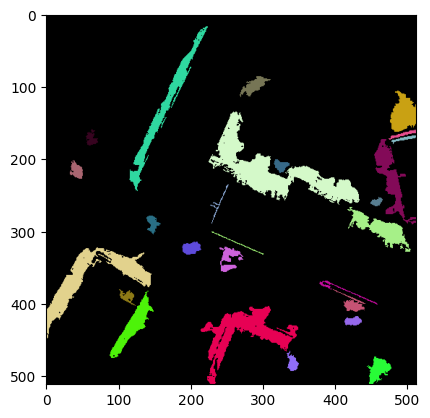

Number of connected components: 27


In [15]:
display_colorized_connected_components_with_size_filtering(binary_image, min_size=100)

## <font color='#90c149'>Highlighting the max of each component</font>
We now color the ndvi maximum of each connected component.

In [16]:
from count.processing import coords_max_ndvi_component
from count.display import display_result

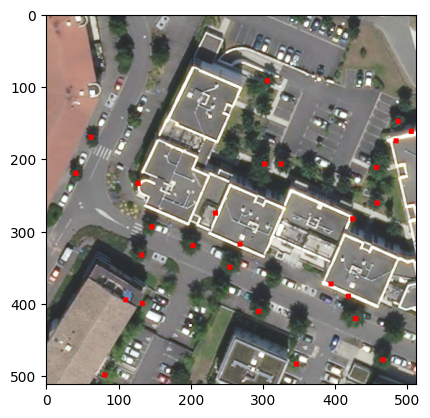

In [17]:
display_result(image, coords_of_maximums=coords_max_ndvi_component(image,  min_size=100))

## <font color='#90c149'>Highlighting local maximums</font>
We now color the ndvi local maximums of each connexe components.

In [18]:
from count.processing import local_maximums_of_ndvi_connexe_components
from count.processing import show_trees
from count.processing import RGB, binary_map_clean, NDVI

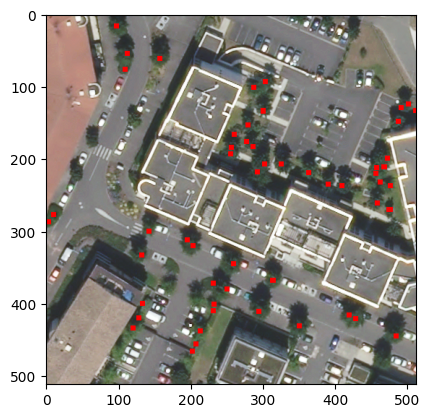

Image saved in output/output_image2.jpg


In [26]:
tif_path1 = "./flair/dataflair/flair_1_toy_aerial_train/D031_2019/Z8_UU/img/IMG_020484.tif"
tif_image1 = read_tif_image(tif_path1)

ndvi_treshold = 0.24
elevation_threshold_min = 2
elevation_threshold_max = 80
maximum_filter_size = 15
minimum_CC_size = 150
output_name = "output_image2"


_,_ = show_trees(tif_image1, ndvi_treshold=ndvi_treshold , elevation_threshold_min=elevation_threshold_min, elevation_threshold_max=elevation_threshold_max, maximum_filter_size=maximum_filter_size, minimum_CC_size=minimum_CC_size, output_name = output_name)


## <font color='#90c149'>Perform the local maximum for each class independently</font>


In [20]:
from count.data import read_tif_mask
from CNN.utils_cnn import transform_to_only_trees_mask
from count.processing import show_trees_from_mask

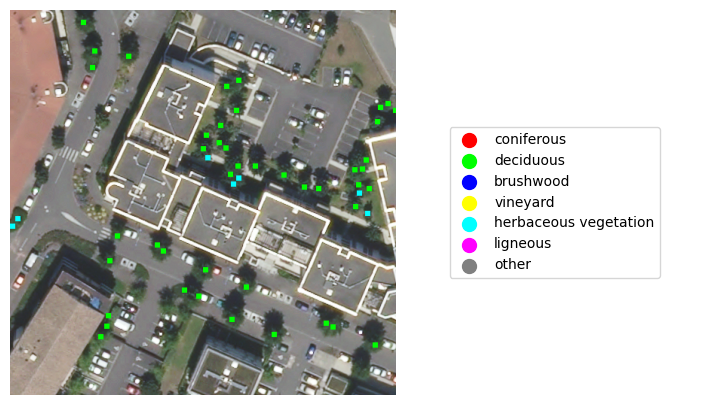

In [44]:
path = "./flair/dataflair/flair_1_toy_labels_train/D031_2019/Z8_UU/msk/MSK_020484.tif"
tif_path = "./flair/dataflair/flair_1_toy_aerial_train/D031_2019/Z8_UU/img/IMG_020484.tif"
tif_image = read_tif_image(tif_path)  



ndvi_treshold = [0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24]
elevation_threshold_min = [2, 2, 2, 2, 2, 2, 2]
elevation_threshold_max = [80, 80, 80, 80, 80, 80, 80]
maximum_filter_size = [15, 15, 15, 15, 15, 15, 15]
minimum_CC_size = [150, 150, 150, 150, 150, 150, 150]
output_name = "output_image"

old_mask = read_tif_mask(path)

show_trees_from_mask(tif_image, old_mask, ndvi_treshold, elevation_threshold_min, elevation_threshold_max, maximum_filter_size, minimum_CC_size, output_name)